<a href="https://colab.research.google.com/github/Muskan-peta/University-Mental-health-risk-grouping/blob/main/Mental_Health_Risk_Grouping_in_University_Students_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


In [2]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.base import clone
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import label_binarize


In [3]:
# optional libs
have_xgb = True
have_cat = True
try:
    from xgboost import XGBClassifier
except Exception:
    have_xgb = False
    print("xgboost not installed; to include it: pip install xgboost")

try:
    from catboost import CatBoostClassifier
except Exception:
    have_cat = False
    print("catboost not installed; to include it: pip install catboost")


catboost not installed; to include it: pip install catboost


In [4]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [5]:
# ---------------- CONFIG ----------------
DATA_PATH = "University_Mental_Health.csv"
CV_FOLDS = 10
RANDOM_STATE = 42
CORR_THRESHOLD = 0.8
IQR_MULTIPLIER = 1.5
ET_ESTIMATORS = 150
RF_ESTIMATORS = 150
# ----------------------------------------


In [6]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")



df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", DATA_PATH, "shape:", df.shape)
print("Columns:", list(df.columns))


Loaded dataset: University_Mental_Health.csv shape: (2000, 19)
Columns: ['student_id', 'age', 'gender', 'course', 'year_of_study', 'cgpa_4pt', 'sleep_hours', 'study_hours', 'physical_activity_days_per_week', 'on_campus_housing', 'part_time_job', 'financial_stress', 'social_support', 'depression', 'anxiety', 'panic_attack', 'seek_treatment', 'risk_score', 'risk_group']


In [7]:
# Detect target columns
target_cols = [c for c in df.columns if c.lower() in ['risk_group', 'risk_score'] or 'risk_group' in c.lower() or 'risk_score' in c.lower()]


In [8]:
# Fallback search if exact not matched
if not target_cols:
    target_cols = [c for c in df.columns if any(k in c.lower() for k in ['risk_group','risk_score','risk','group','score'])]
if not target_cols:
    raise ValueError("Couldn't auto-detect 'risk_group' or 'risk_score' columns. Please ensure the dataset has these columns.")

print("Detected target-related columns (using these if present):", target_cols)


Detected target-related columns (using these if present): ['risk_score', 'risk_group']


In [9]:
# prefer explicit risk_group and risk_score if present
use_risk_group = 'risk_group' in df.columns
use_risk_score = 'risk_score' in df.columns



In [10]:
# If both present, create multi-output classification problem
multi_output = False
if use_risk_group and use_risk_score:
    multi_output = True
    print("Both 'risk_group' and 'risk_score' present -> building multi-output classification (both become categorical targets).")
elif use_risk_group:
    print("Using 'risk_group' as target (classification).")
elif use_risk_score:
    print("Using 'risk_score' as target (will discretize into categories).")



Both 'risk_group' and 'risk_score' present -> building multi-output classification (both become categorical targets).


In [11]:
# Build X and y(s)
y_targets = []
if use_risk_group:
    y_rg_raw = df['risk_group'].astype(str).copy()
    le_rg = LabelEncoder()
    y_rg = le_rg.fit_transform(y_rg_raw)
    y_targets.append(('risk_group', y_rg, le_rg.classes_))
if use_risk_score:
    # discretize into 4 bins (quartiles) to make classification target
    # If already categorical, encode as-is
    if pd.api.types.is_numeric_dtype(df['risk_score']):
        try:
            y_rs_cat, bins = pd.qcut(df['risk_score'], q=4, labels=False, retbins=True, duplicates='drop')
            # if duplicates cause fewer bins, handle by labeling
            y_rs = y_rs_cat.astype(int).values
            print(f"'risk_score' converted to {len(np.unique(y_rs))} bins (quartiles).")
        except Exception as e:
            # fallback: simple label-encoding by rounding
            y_rs = pd.qcut(df['risk_score'].rank(method='first'), q=4, labels=False).astype(int).values
            print("'risk_score' discretized (fallback).")
        le_rs = None  # bins are numeric labels
    else:
        le_rs = LabelEncoder()
        y_rs = le_rs.fit_transform(df['risk_score'].astype(str))
    y_targets.append(('risk_score', y_rs, None))


'risk_score' converted to 4 bins (quartiles).


In [12]:
# Decide primary target for stratification: prefer risk_group if present
if use_risk_group:
    stratify_y = y_rg
else:
    stratify_y = y_targets[0][1]  # first target


In [13]:
# Features: drop target columns
X = df.drop(columns=[c for c in ['risk_group','risk_score'] if c in df.columns]).copy()
print("Feature matrix shape (after dropping target columns):", X.shape)


Feature matrix shape (after dropping target columns): (2000, 17)


In [14]:
# Convert CGPA 4.0 -> 10.0 for detected cgpa/gpa columns
gpa_cols = [c for c in X.columns if any(k in c.lower() for k in ['cgpa','gpa'])]
converted = []
for c in gpa_cols:
    colnum = pd.to_numeric(X[c], errors='coerce')
    if colnum.max(skipna=True) <= 4.0 + 1e-8:
        X[c] = colnum * (10.0 / 4.0)
        converted.append(c)
print("GPA-like columns detected:", gpa_cols, "Converted:", converted)


GPA-like columns detected: ['cgpa_4pt'] Converted: ['cgpa_4pt']


In [15]:
# Drop columns with >90% missing or single unique value
thresh = 0.9 * len(X)
drop_cols = [c for c in X.columns if X[c].isna().sum() > thresh or X[c].nunique(dropna=True) <= 1]
if drop_cols:
    print("Dropping columns with too many missing/single-value:", drop_cols)
    X.drop(columns=drop_cols, inplace=True)



In [16]:
# Fill missing: numeric->median, categorical->'MISSING'
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
if num_cols:
    X[num_cols] = X[num_cols].apply(pd.to_numeric, errors='coerce')
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())
if cat_cols:
    X[cat_cols] = X[cat_cols].fillna("MISSING")

print("Numeric features:", num_cols)
print("Categorical features (first 20):", cat_cols[:20])


Numeric features: ['student_id', 'age', 'year_of_study', 'cgpa_4pt', 'sleep_hours', 'study_hours', 'physical_activity_days_per_week']
Categorical features (first 20): ['gender', 'course', 'on_campus_housing', 'part_time_job', 'financial_stress', 'social_support', 'depression', 'anxiety', 'panic_attack', 'seek_treatment']


In [17]:
# Outlier removal (IQR) on numeric columns
def iqr_filter(df_num, multiplier=1.5):
    Q1 = df_num.quantile(0.25)
    Q3 = df_num.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    mask = ~((df_num < lower) | (df_num > upper)).any(axis=1)
    return mask

if len(num_cols) > 0:
    mask_keep = iqr_filter(X[num_cols], multiplier=IQR_MULTIPLIER)
    removed = (~mask_keep).sum()
    X = X.loc[mask_keep].reset_index(drop=True)
    # apply mask to targets
    for idx, t in enumerate(y_targets):
        name, arr, lab = t
        y_targets[idx] = (name, np.array(arr)[mask_keep.values], lab)
    print(f"Outlier removal: removed {removed} rows; remaining {len(X)} rows.")
else:
    print("No numeric columns; skipping outlier removal.")


Outlier removal: removed 17 rows; remaining 1983 rows.


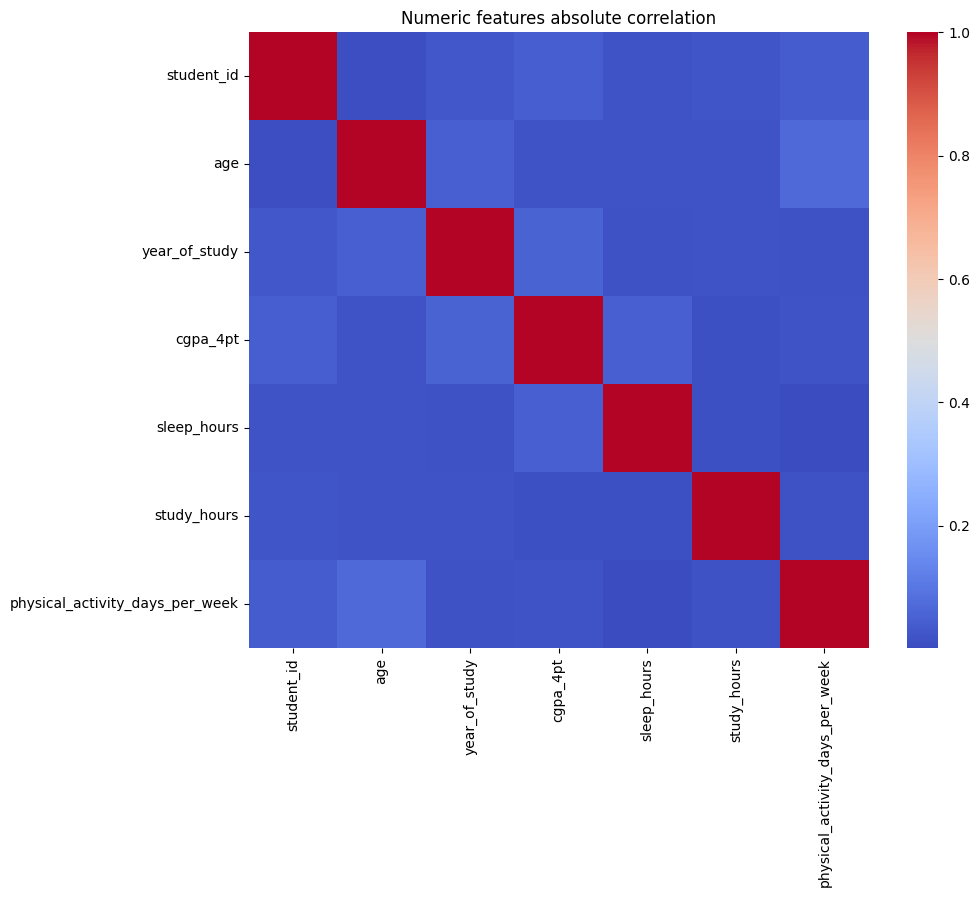

No features exceeded correlation threshold.


In [18]:
# Correlation matrix & drop highly correlated (|corr| >= CORR_THRESHOLD)
if len(num_cols) > 1:
    corr = X[num_cols].corr().abs()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm')
    plt.title("Numeric features absolute correlation")
    plt.show()

    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = []
    for col in upper.columns:
        high = upper.index[upper[col] >= CORR_THRESHOLD].tolist()
        for other in high:
            mean_col = corr[col].mean()
            mean_other = corr[other].mean()
            drop_cand = col if mean_col >= mean_other else other
            if drop_cand not in to_drop:
                to_drop.append(drop_cand)
    if to_drop:
        print(f"Dropping correlated features (|corr| >= {CORR_THRESHOLD}):", to_drop)
        X.drop(columns=to_drop, inplace=True)
        # update num_cols
        num_cols = [c for c in num_cols if c not in to_drop]
    else:
        print("No features exceeded correlation threshold.")
else:
    print("Not enough numeric features to compute correlation matrix.")


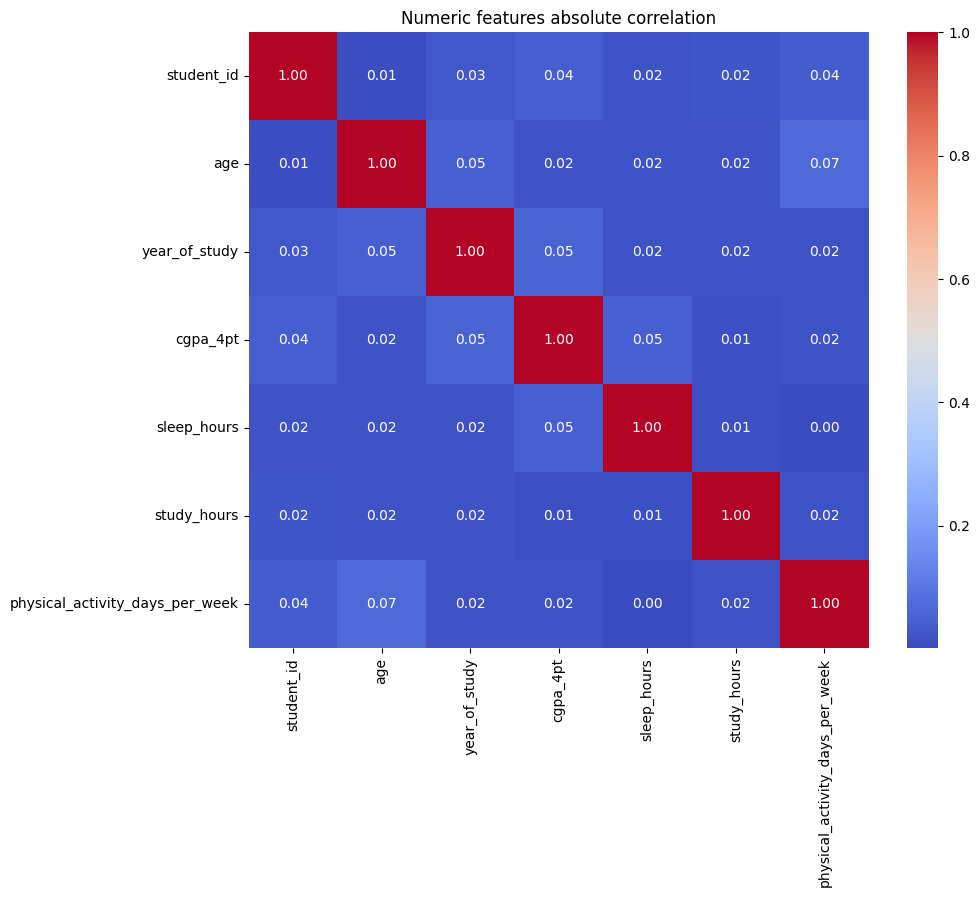

No features exceeded correlation threshold.


In [19]:
if len(num_cols) > 1:
    corr = X[num_cols].corr().abs()

    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")  # <- added annot=True, fmt=".2f"
    plt.title("Numeric features absolute correlation")
    plt.show()

    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = []
    for col in upper.columns:
        high = upper.index[upper[col] >= CORR_THRESHOLD].tolist()
        for other in high:
            mean_col = corr[col].mean()
            mean_other = corr[other].mean()
            drop_cand = col if mean_col >= mean_other else other
            if drop_cand not in to_drop:
                to_drop.append(drop_cand)

    if to_drop:
        print(f"Dropping correlated features (|corr| >= {CORR_THRESHOLD}):", to_drop)
        X.drop(columns=to_drop, inplace=True)
        # update num_cols
        num_cols = [c for c in num_cols if c not in to_drop]
    else:
        print("No features exceeded correlation threshold.")
else:
    print("Not enough numeric features to compute correlation matrix.")


In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')


In [21]:
# Define base classifiers
rng = RANDOM_STATE
base_classifiers = {
    'ExtraTrees': ExtraTreesClassifier(n_estimators=ET_ESTIMATORS, random_state=rng, n_jobs=-1),
    'RandomForest': RandomForestClassifier(n_estimators=RF_ESTIMATORS, random_state=rng, n_jobs=-1),
    'NuSVM': NuSVC(probability=True, random_state=rng),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=rng)
}
if have_xgb:
    base_classifiers['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=rng, n_jobs=-1)
if have_cat:
    base_classifiers['CatBoost'] = CatBoostClassifier(verbose=0, random_state=rng)



In [24]:
# For multi-output scenario, wrap each classifier with MultiOutputClassifier for consistent behavior
def make_model(name, clf, multi_output_flag):
    if multi_output_flag:
        return MultiOutputClassifier(clone(clf), n_jobs=-1)
    else:
        return clone(clf)



In [25]:
# Choose cross-validation splitter (prefer stratify by risk_group if present)
if use_risk_group:
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    stratify_base = y_targets[[i for i,t in enumerate(y_targets) if t[0]=='risk_group'][0]][1]
else:
    cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    stratify_base = None


In [26]:
# We'll perform a manual CV loop to support multi-output easily and compute metrics per output
def compute_metrics_per_output(y_true_list, y_pred_list):
    """
    y_true_list: list of arrays for each output (len = n_outputs)
    y_pred_list: same shape
    Returns per-output metrics dict and averaged metrics
    """
    n_outputs = len(y_true_list)
    metrics_per_output = []
    for i in range(n_outputs):
        yt = y_true_list[i]
        yp = y_pred_list[i]
        acc = accuracy_score(yt, yp)
        prec = precision_score(yt, yp, average='macro', zero_division=0)
        rec = recall_score(yt, yp, average='macro', zero_division=0)
        f1 = f1_score(yt, yp, average='macro', zero_division=0)
        metrics_per_output.append({'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1})
    # average across outputs
    avg = {k: np.mean([m[k] for m in metrics_per_output]) for k in metrics_per_output[0].keys()}
    return metrics_per_output, avg


In [27]:
# Prepare target arrays for CV
y_arrays = [t[1] for t in y_targets]   # list of numpy arrays, one per output
target_names = [t[0] for t in y_targets]
n_outputs = len(y_arrays)
print("Targets used (order):", target_names)



Targets used (order): ['risk_group', 'risk_score']


In [28]:
# Evaluate each classifier with manual CV
results = {}
roc_results = {}

for name, clf in base_classifiers.items():
    print("\nEvaluating:", name)
    model = make_model(name, clf, multi_output)
    pipe = Pipeline([('pre', preprocessor), ('clf', model)])

    # store metrics across folds and across outputs
    fold_metrics = []
    fold_roc = [[] for _ in range(n_outputs)]

    # iterate folds
    # build indices using stratify on primary target if possible
    if use_risk_group:
        splits = cv.split(X, stratify_base)
    else:
        splits = cv.split(X)

    for fold_idx, (train_idx, test_idx) in enumerate(splits):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = [arr[train_idx] for arr in y_arrays]
        y_test = [arr[test_idx] for arr in y_arrays]

        # fit model
        y_train_stack = np.vstack(y_train).T if n_outputs > 1 else y_train[0]
        y_test_stack = np.vstack(y_test).T if n_outputs > 1 else y_test[0]

        m = clone(pipe)
        try:
            m.fit(X_train, y_train_stack)
        except Exception as e:
            print(f"  Fold {fold_idx}: training failed for {name}: {e}")
            continue

        # predict
        y_pred_stack = m.predict(X_test)

        # convert predictions into list per output
        if n_outputs == 1:
            y_pred_list = [y_pred_stack]
        else:
            y_pred_list = [y_pred_stack[:, i] for i in range(n_outputs)]

        # metrics
        _, avg_metrics = compute_metrics_per_output(y_test, y_pred_list)
        fold_metrics.append(avg_metrics)

        # compute ROC-AUC if possible
        for out_i in range(n_outputs):
            auc_val = np.nan
            try:
                clf_pipeline = m.named_steps['clf']

                if hasattr(clf_pipeline, 'estimators_'):
                    est = clf_pipeline.estimators_[out_i]
                    try:
                        y_score = est.predict_proba(m.named_steps['pre'].transform(X_test))
                        if y_score.ndim == 2:
                            if len(np.unique(y_test[out_i])) == 2:
                                auc_val = roc_auc_score(y_test[out_i], y_score[:, 1])
                            else:
                                y_test_b = label_binarize(y_test[out_i], classes=np.unique(y_test[out_i]))
                                auc_val = roc_auc_score(y_test_b, y_score, average='macro', multi_class='ovr')
                    except Exception:
                        try:
                            dec = est.decision_function(m.named_steps['pre'].transform(X_test))
                            if len(np.unique(y_test[out_i])) == 2:
                                auc_val = roc_auc_score(y_test[out_i], dec)
                            else:
                                y_test_b = label_binarize(y_test[out_i], classes=np.unique(y_test[out_i]))
                                auc_val = roc_auc_score(y_test_b, dec, average='macro', multi_class='ovr')
                        except Exception:
                            auc_val = np.nan
                else:
                    # single-output classifier
                    try:
                        y_score = m.predict_proba(X_test)
                        if isinstance(y_score, list):
                            auc_val = np.nan
                        else:
                            if n_outputs == 1 and y_score.ndim == 2:
                                if len(np.unique(y_test[0])) == 2:
                                    auc_val = roc_auc_score(y_test[0], y_score[:, 1])
                    except Exception:
                        auc_val = np.nan

            except Exception:
                auc_val = np.nan

            fold_roc[out_i].append(auc_val)

    # aggregate fold_metrics
    if fold_metrics:
        metrics_mean = {k: np.mean([fm[k] for fm in fold_metrics]) for k in fold_metrics[0].keys()}
    else:
        metrics_mean = {'accuracy': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1': np.nan}

    results[name] = {'fold_metrics': metrics_mean}
    roc_results[name] = [np.nanmean(arr) if arr else np.nan for arr in fold_roc]

    print(f"  Mean metrics: {metrics_mean}")
    print(f"  Mean ROC-AUC per output: {roc_results[name]}")



Evaluating: ExtraTrees
  Mean metrics: {'accuracy': np.float64(0.9044464747982335), 'precision': np.float64(0.9021577722892941), 'recall': np.float64(0.8839979818032774), 'f1': np.float64(0.8903548354970928)}
  Mean ROC-AUC per output: [np.float64(0.9909430427278307), np.float64(0.9802086417118435)]

Evaluating: RandomForest
  Mean metrics: {'accuracy': np.float64(0.9309197502664839), 'precision': np.float64(0.9258903152417982), 'recall': np.float64(0.9178900666015382), 'f1': np.float64(0.920168015172878)}
  Mean ROC-AUC per output: [np.float64(0.9938770662200287), np.float64(0.9880053533952585)]

Evaluating: NuSVM
  Fold 0: training failed for NuSVM: specified nu is infeasible
  Fold 1: training failed for NuSVM: specified nu is infeasible
  Fold 2: training failed for NuSVM: specified nu is infeasible
  Fold 3: training failed for NuSVM: specified nu is infeasible
  Fold 4: training failed for NuSVM: specified nu is infeasible
  Fold 5: training failed for NuSVM: specified nu is inf

In [30]:
# Build summary table and select top-3 by average of acc/prec/rec/f1
summary_rows = []

for name, res in results.items():
    mm = res['fold_metrics']  # <-- corrected key
    avg_metric = np.mean([mm['accuracy'], mm['precision'], mm['recall'], mm['f1']])
    summary_rows.append({
        'model': name,
        'accuracy': mm['accuracy'],
        'precision': mm['precision'],
        'recall': mm['recall'],
        'f1': mm['f1'],
        'avg': avg_metric
    })

summary_df = (
    pd.DataFrame(summary_rows)
    .sort_values('avg', ascending=False)
    .reset_index(drop=True)
)

print("\nSummary of evaluated classifiers (averaged across CV folds and outputs):")
print(summary_df)

top3 = summary_df.head(3)['model'].tolist()
print("\nTop-3 selected models for ensemble:", top3)



Summary of evaluated classifiers (averaged across CV folds and outputs):
          model  accuracy  precision    recall        f1       avg
0       XGBoost  0.950585   0.944771  0.939823  0.941182  0.944090
1           MLP  0.940494   0.936033  0.922148  0.927073  0.931437
2  RandomForest  0.930920   0.925890  0.917890  0.920168  0.923717
3    ExtraTrees  0.904446   0.902158  0.883998  0.890355  0.895239
4         NuSVM       NaN        NaN       NaN       NaN       NaN

Top-3 selected models for ensemble: ['XGBoost', 'MLP', 'RandomForest']


In [31]:
# Build Voting ensemble using the original base classifiers (wrapped similarly if multi-output)
estimators_for_voting = [(n, base_classifiers[n]) for n in top3]


In [32]:
# Determine whether soft voting possible: try to check predict_proba support by light fitting on small subset
def supports_predict_proba(clf):
    try:
        if hasattr(clf, "predict_proba"):
            return True
        else:
            return False
    except Exception:
        return False

all_support_proba = True


In [33]:
# quick local check on small sample
try:
    sample_X = X.iloc[:min(100, len(X))]
    sample_y = [arr[:len(sample_X)] for arr in y_arrays]
    sample_y_stack = np.vstack(sample_y).T if n_outputs > 1 else sample_y[0]
    for name, base in estimators_for_voting:
        c = clone(base)
        try:
            c.fit(preprocessor.fit_transform(sample_X), sample_y_stack)  # note: fit on transformed array if needed
            if not supports_predict_proba(c):
                all_support_proba = False
                break
        except Exception:
            all_support_proba = False
            break
except Exception:
    all_support_proba = False

voting_type = 'soft' if all_support_proba else 'hard'
print("Ensemble voting type:", voting_type)

voting = VotingClassifier(estimators=estimators_for_voting, voting=voting_type, n_jobs=-1)
if multi_output:
    voting_model = MultiOutputClassifier(voting, n_jobs=-1)
else:
    voting_model = voting


Ensemble voting type: hard


In [34]:
print("\nEvaluating Ensemble...")

ensemble_pipe = Pipeline([('pre', preprocessor), ('clf', voting_model)])
fold_metrics = []
fold_roc = [[] for _ in range(n_outputs)]

if use_risk_group:
    splits = cv.split(X, stratify_base)
else:
    splits = cv.split(X)

for fold_idx, (train_idx, test_idx) in enumerate(splits):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = [arr[train_idx] for arr in y_arrays]
    y_test = [arr[test_idx] for arr in y_arrays]

    y_train_stack = np.vstack(y_train).T if n_outputs > 1 else y_train[0]

    m = clone(ensemble_pipe)
    try:
        m.fit(X_train, y_train_stack)
    except Exception as e:
        print(f"  Ensemble training failed on fold {fold_idx}: {e}")
        continue

    y_pred_stack = m.predict(X_test)

    if n_outputs == 1:
        y_pred_list = [y_pred_stack]
    else:
        y_pred_list = [y_pred_stack[:, i] for i in range(n_outputs)]

    _, avg_metrics = compute_metrics_per_output(y_test, y_pred_list)
    fold_metrics.append(avg_metrics)

    # ROC-AUC attempts (per output)
    for out_i in range(n_outputs):
        auc_val = np.nan
        try:
            clf_pipeline = m.named_steps['clf']

            if hasattr(clf_pipeline, 'estimators_'):
                est = clf_pipeline.estimators_[out_i]
                try:
                    y_score = est.predict_proba(m.named_steps['pre'].transform(X_test))
                    if len(np.unique(y_test[out_i])) == 2:
                        auc_val = roc_auc_score(y_test[out_i], y_score[:, 1])
                    else:
                        y_test_b = label_binarize(y_test[out_i], classes=np.unique(y_test[out_i]))
                        auc_val = roc_auc_score(y_test_b, y_score, average='macro', multi_class='ovr')
                except Exception:
                    try:
                        dec = est.decision_function(m.named_steps['pre'].transform(X_test))
                        if len(np.unique(y_test[out_i])) == 2:
                            auc_val = roc_auc_score(y_test[out_i], dec)
                        else:
                            y_test_b = label_binarize(y_test[out_i], classes=np.unique(y_test[out_i]))
                            auc_val = roc_auc_score(y_test_b, dec, average='macro', multi_class='ovr')
                    except Exception:
                        auc_val = np.nan
            else:
                # single-output ensemble
                try:
                    y_score = m.predict_proba(X_test)
                    if n_outputs == 1 and y_score.ndim == 2:
                        if len(np.unique(y_test[0])) == 2:
                            auc_val = roc_auc_score(y_test[0], y_score[:, 1])
                        else:
                            auc_val = np.nan
                except Exception:
                    auc_val = np.nan

        except Exception:
            auc_val = np.nan

        fold_roc[out_i].append(auc_val)

# Aggregate metrics
ensemble_mean_metrics = {k: np.mean([fm[k] for fm in fold_metrics])
                         for k in fold_metrics[0].keys()} if fold_metrics else \
                        {'accuracy': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1': np.nan}

ensemble_roc_mean = [np.nanmean(arr) if arr else np.nan for arr in fold_roc]

print("Ensemble mean metrics:", ensemble_mean_metrics)
print("Ensemble ROC-AUC per output:", ensemble_roc_mean)



Evaluating Ensemble...
Ensemble mean metrics: {'accuracy': np.float64(0.9513374955586011), 'precision': np.float64(0.9479626333792689), 'recall': np.float64(0.9424976711114839), 'f1': np.float64(0.9441053038870679)}
Ensemble ROC-AUC per output: [np.float64(nan), np.float64(nan)]


In [35]:
# Comparison table: top3 individuals vs ensemble
compare_rows = []

for m in top3:
    mm = results[m]['fold_metrics']  # <-- fixed key
    compare_rows.append({
        'model': m,
        'accuracy': mm['accuracy'],
        'precision': mm['precision'],
        'recall': mm['recall'],
        'f1': mm['f1'],
        'roc_auc_avg': np.nanmean(roc_results[m])
    })

compare_rows.append({
    'model': 'Ensemble(' + "+".join(top3) + ')',
    'accuracy': ensemble_mean_metrics['accuracy'],
    'precision': ensemble_mean_metrics['precision'],
    'recall': ensemble_mean_metrics['recall'],
    'f1': ensemble_mean_metrics['f1'],
    'roc_auc_avg': np.nanmean(ensemble_roc_mean)
})

compare_df = pd.DataFrame(compare_rows).sort_values('f1', ascending=False).reset_index(drop=True)
print("\nTop-3 vs Ensemble comparison:")
print(compare_df)



Top-3 vs Ensemble comparison:
                                model  accuracy  precision    recall  \
0  Ensemble(XGBoost+MLP+RandomForest)  0.951337   0.947963  0.942498   
1                             XGBoost  0.950585   0.944771  0.939823   
2                                 MLP  0.940494   0.936033  0.922148   
3                        RandomForest  0.930920   0.925890  0.917890   

         f1  roc_auc_avg  
0  0.944105          NaN  
1  0.941182     0.995054  
2  0.927073     0.995208  
3  0.920168     0.990941  


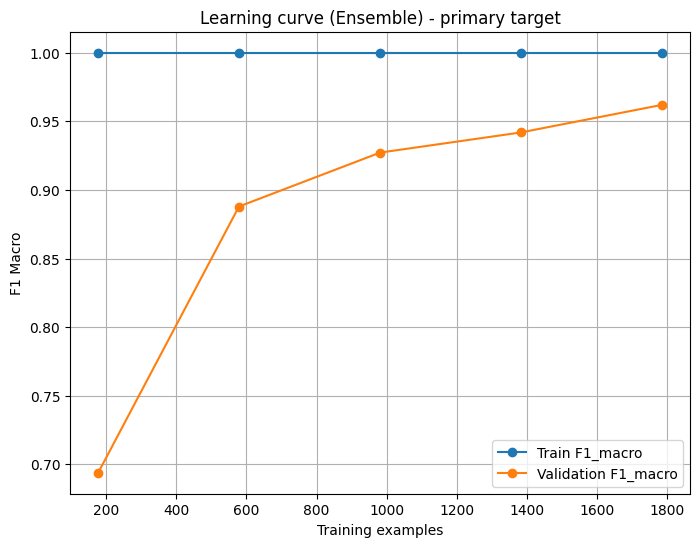

In [36]:
# Learning curve (training vs validation) for the ensemble on primary target (risk_group if available)
# If multi-output, we take the first target (primary) for learning curve visuals
primary_target_for_learning = y_targets[0][1]  # first target array

# Build a pipeline for single-output learning curve (primary target)
single_output_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', voting if n_outputs == 1 else clone(voting))
])

from sklearn.model_selection import learning_curve

try:
    train_sizes, train_scores, test_scores = learning_curve(
        single_output_pipe, X, primary_target_for_learning,
        cv=cv, scoring='f1_macro', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Train F1_macro')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation F1_macro')
    plt.xlabel("Training examples")
    plt.ylabel("F1 Macro")
    plt.title("Learning curve (Ensemble) - primary target")
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print("Could not compute learning curve:", e)


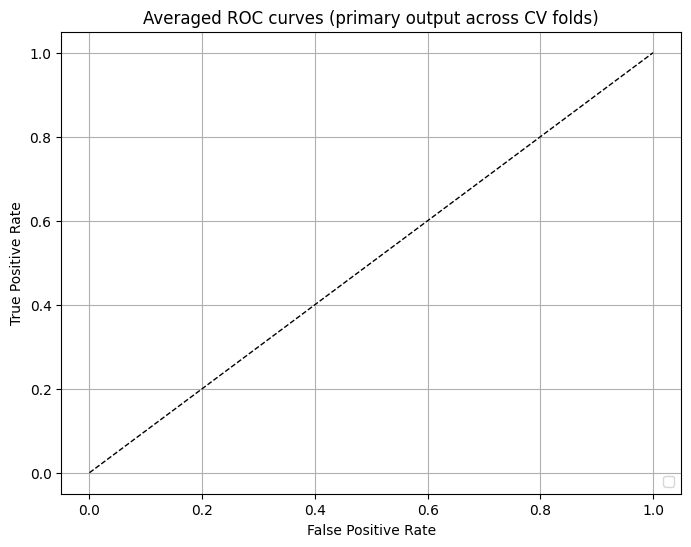

In [37]:
# Averaged ROC curves: top3 individuals + ensemble
mean_fpr = np.linspace(0,1,100)
plt.figure(figsize=(8,6))
models_to_plot = top3 + ['Ensemble']
for name in models_to_plot:
    tprs = []
    aucs = []
    # run CV again folds
    if use_risk_group:
        splits = cv.split(X, stratify_base)
    else:
        splits = cv.split(X)
    for train_idx, test_idx in splits:
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = [arr[train_idx] for arr in y_arrays]
        y_test = [arr[test_idx] for arr in y_arrays]
        y_train_stack = np.vstack(y_train).T if n_outputs>1 else y_train[0]
        if name == 'Ensemble':
            pipe = clone(ensemble_pipe)
        else:
            m = make_model(name, base_classifiers[name], multi_output)
            pipe = Pipeline([('pre', preprocessor), ('clf', m)])
        try:
            pipe.fit(X_train, y_train_stack)
            # predict_proba for the primary output only (index 0)
            if multi_output:
                # extract the estimator for first output and call predict_proba on preprocessed X_test
                clf_wrap = pipe.named_steps['clf']
                if hasattr(clf_wrap, 'estimators_'):
                    est = clf_wrap.estimators_[0]
                    try:
                        X_test_tr = pipe.named_steps['pre'].transform(X_test)
                        y_score = est.predict_proba(X_test_tr)
                        if y_score.ndim == 2:
                            if len(np.unique(y_test[0]))==2:
                                fpr, tpr, _ = roc_curve(y_test[0], y_score[:,1])
                                tprs.append(np.interp(mean_fpr, fpr, tpr))
                                aucs.append(auc(fpr,tpr))
                            else:
                                # multiclass: compute per-class, then average
                                pass
                    except Exception:
                        continue
                else:
                    # single-output pipeline
                    try:
                        y_score = pipe.predict_proba(X_test)
                        if y_score.ndim==2 and len(np.unique(y_test[0]))==2:
                            fpr, tpr, _ = roc_curve(y_test[0], y_score[:,1])
                            tprs.append(np.interp(mean_fpr, fpr, tpr))
                            aucs.append(auc(fpr,tpr))
                    except Exception:
                        continue
            else:
                try:
                    y_score = pipe.predict_proba(X_test)
                    if y_score.ndim==2 and len(np.unique(y_test))==2:
                        fpr, tpr, _ = roc_curve(y_test, y_score[:,1])
                        tprs.append(np.interp(mean_fpr, fpr, tpr))
                        aucs.append(auc(fpr,tpr))
                except Exception:
                    continue
        except Exception:
            continue
    if tprs:
        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = np.mean(aucs)
        plt.plot(mean_fpr, mean_tpr, label=f"{name} (AUC {mean_auc:.3f})")
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Averaged ROC curves (primary output across CV folds)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [38]:
# Save summaries
summary_df.to_csv("models_summary.csv", index=False)
compare_df.to_csv("top3_vs_ensemble.csv", index=False)
print("Saved models_summary.csv and top3_vs_ensemble.csv")

print("Pipeline complete. Top-3 models:", top3)


Saved models_summary.csv and top3_vs_ensemble.csv
Pipeline complete. Top-3 models: ['XGBoost', 'MLP', 'RandomForest']
